# Barlow Twins for Contrastive SSL.
### Barlow Twins 对比自监督学习

原文链接：https://keras.io/examples/vision/barlow_twins/

## Note:


**这个例子十分吃显存和内存，建议内存在32GB以上，现存在6GB以上**


自监督学习大部分人已经有一个概念了，对比自监督学习其实是自监督学习的一种，其本质仍然是不依靠标签，从无标签的图中学习到特征。图像领域的自监督可以分成两类：生成式和判别式。知乎博主 **Microstrong** 在其博客 [机器学习中的判别式模型和生成式模型](https://zhuanlan.zhihu.com/p/74586507) 中对两种模型进行了详细介绍，总结得到如下信息：  
* 生成式：对联合分布建模 $\sum{P(x,y)}=1$
* 判别式：对条件分布建模 $\sum{P(y|x)}=1$


<table>
<tr>
    <td rowspan="7"> 判别式
    <td>Logistic Regression</td>
    <td>逻辑回归</td>
</tr>
<tr>
    <td>Linear Discriminant Analysis</td>
    <td>线性判别分析</td>
</tr>
<tr>
    <td>Support Vector Machines</td>
    <td>支持向量机</td>
</tr>
<tr>
    <td>Boosting</td>
    <td>监督学习提升算法</td>
</tr>
<tr>
    <td>Conditional Random Fields</td>
    <td>条件随机场</td>
</tr>
<tr>
    <td>Linear Regression</td>
    <td>线性回归</td>
</tr>
<tr>
    <td>Classiifcation Neural Networks</td>
    <td>分类神经网络</td>
</tr>
<!-- -->
<tr>
    <td rowspan="7"> 生成式
    <td>Gaussian Mixture Model</td>
    <td>高斯混合模型</td>
</tr>
<tr>
    <td>Hidden Markov Model</td>
    <td>隐式马尔可夫模型</td>
</tr>
<tr>
    <td>Naive Bayes</td>
    <td>朴素贝叶斯</td>
</tr>
<tr>
    <td>Restricted Boltzmann Machine</td>
    <td>有限玻尔兹曼机</td>
</tr>
</table> 


以一个“语言”例子说明两者之间的区别：
* 生成式：把所有国家的语言都学会，那么自然就知道对方说的什么语言，并且自己也会说任何语言；
* 判别式：只要知道两两语言之间的差异就行，能够区分两个语言，但自己并不会说任何语言；

例如，如何区分中文和法语。生成式需要把中文和法语全部学会，而判别式只需要知道中文是象形文字，而法语是拼音文字即可。  

有了上述概念就可以知道VAE、GAN是生成式方法，而本文所引入的对比学习就是典型的判别式方法。假设现在有两类图片如下图所示。  

<img src='../images/CV_Img/CSSL.png'>  

虽然类间图片存在一定差异，但仍然是同一类的图片。那么对比自监督学习就是找到一个模型，即便是天空颜色不一样也要把两者尽可能地映射到同一个向量上，同时天空向量和城市向量尽可能正交。即缩小同类样本之间的距离，扩大异类样本的距离。  

到此处你可能会有疑问，那我们之前做的不一直是这个么？找到一个模型能够区分不同类别样本。这里需要注意下，之前的工作大多数是在有标签的情况下完成的，这意味着我们对训练集每个样本的信息都很清楚，但现在的环境是无标签，更类似于无监督的 KNN 聚类。  

至此标题的一半 “对比自监督学习” 算是解释完了，另一半 “Barlow Twins” 其实就是一种改进的算法。

这里有几个非常好的相关博客推荐给大家，对此处感兴趣的可以阅读下。
* 光某人 [对比学习（Contrastive Learning）综述](https://zhuanlan.zhihu.com/p/346686467)
* 明也 [自监督学习--深度学习的魔法](https://zhuanlan.zhihu.com/p/383929440)
* 张俊林 [对比学习（Contrastive Learning）:研究进展精要](https://zhuanlan.zhihu.com/p/367290573)

以及该算法的原始论文 [Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/abs/2103.03230)

----------

## Introduction
Self-supervised learning (SSL) is a relatively novel technique in which a model learns from unlabeled data, and is often used when the data is corrupted or if there is very little of it. A practical use for SSL is to create intermediate embeddings that are learned from the data. These embeddings are based on the dataset itself, with similar images having similar embeddings, and vice versa. They are then attached to the rest of the model, which uses those embeddings as information and effectively learns and makes predictions properly. These embeddings, ideally, should contain as much information and insight about the data as possible, so that the model can make better predictions. However, a common problem that arises is that the model creates embeddings that are redundant. For example, if two images are similar, the model will create embeddings that are just a string of 1's, or some other value that contains repeating bits of information. This is no better than a one-hot encoding or just having one bit as the model’s representations; it defeats the purpose of the embeddings, as they do not learn as much about the dataset as possible. For other approaches, the solution to the problem was to carefully configure the model such that it tries not to be redundant.  
自监督学习（SSL）是一种相对新颖的技术，其中模型从未标记的数据中学习，并且通常在数据损坏或数据很少的情况下使用。SSL的一个实际用途是创建从数据中学习的中间嵌入（特征），这些嵌入基于数据集本身的，相似的图像有相近的嵌入。然后模型使用这些嵌入作为信息学习和预测。理想条件下，这些嵌入需要包含了数据集中尽可能多样的信息。但实际情况是存在冗余的嵌入。如，对于两个相似度较高的图像，模型可能会创建一串“1”，或者包含重复信息的其他嵌入，这样的操作并不one-hot或者使用一个比特位表示更好，这和嵌入的初衷背离因为模型并没有从数据集中尽可能多地学到信息。解决这个问题的方法是让模型尽量不冗余。  

Barlow Twins is a new approach to this problem; while other solutions mainly tackle the first goal of invariance (similar images have similar embeddings), the Barlow Twins method also prioritizes the goal of reducing redundancy.  
Barlow Twins是解决冗余问腿的一个新方法。虽然其他方法主要解决的是不变性的第一个目标（相似的图像有相似的嵌入），但Barlow Twins在次基础上有限考虑了如何减少冗余。  

It also has the advantage of being much simpler than other methods, and its model architecture is symmetric, meaning that both twins in the model do the same thing. It is also near state-of-the-art on imagenet, even exceeding methods like SimCLR.  
该方法还比其他方法简单很多，并且模型结构是对称的，这意味着模型的两个支路能做完全相同的事。在ImageNet上也达到了SOTA，甚至超越了SimCLR方法。  

One disadvantage of Barlow Twins is that it is heavily dependent on augmentation, suffering major performance decreases in accuracy without them.  
Barlow Twins的一个缺陷是其严重依赖与数据增强，如果没有这部分，准确性将大幅下降。  

TL, DR: Barlow twins creates representations that are:   
* Invariant. 不变性。
* Not redundant, and carry as much info about the dataset. 非冗余，并携带数据集中尽可能多的关键信息。


这里引入了一两个概念，不变性（Invariant）和等变性（Equivarient），知乎博主 **Lunarnai** 在其博客 [CNN中的equivariant vs. invariant](https://zhuanlan.zhihu.com/p/41682204) 中对这两个概念进行了概述，总结起来如下：  

* 等变性 Equivariant：对输入施加的变化会反应在输出上；
* 不变性 Invarient：对输入的变化不会反应在输出上；

那么，对于一个有标签的分类网络而言，期望的是不变性，即无论图中的对象如何形变（镜像、翻转、平移）都不改变分类结果；而对于回归网络而言，期望的是等变性，即对象位置发生改变其输出的坐标值也要变化。  

在此处，由于我们的目标仍然是做无监督的分类，那么不变性则是主要追求的指标。

该博客将按照下图所示结构搭建Barlow Twins模型。

<img src='../images/CV_Img/G6LnEPT.png'>

## High-Level Theory
The model takes two versions of the same image(with different augmentations) as input. Then it takes a prediction of each of them, creating representations. They are then used to make a cross-correlation matrix.  
该模型将同一幅图像的两种增强结果作为输入，对每种结果进行预测，将预测结果用于构造互相关矩阵。

```python
Cross-correlation matrix:
    (pred_1.T @ pred_2) / batch_size
```

The cross-correlation matrix measures the correlation between the output neurons in the two representations made by the model predictions of the two augmented versions of data. Ideally, a cross-correlation matrix should look like an identity matrix if the two images are the same.  
互相关矩阵衡量的是两个输入在完成特征抽取后输出的相关性（图中即为 $Z^{A}$ 和 $Z^{B}$ 的相关性）。在理想状态下，如果两个图像相同那么互相关矩阵为单位矩阵。（这其实是我们所期待的，尽管对图像进行了不同程度的增强，但图像中的内容不应该发生变化，两个输出特征的相关性矩阵应该为单位矩阵）  

When this happens, it means that the representations:  
当发生这种情况时，则意味着：  
* Are invariant. The diagonal shows the correlation between each representation's neurons and its corresponding augmented one. Because the two versions come from the same image, the diagonal of the matrix should show that there is a strong correlation between them. If the images are different, there shouldn't be a diagonal.
* 模型是不变的。对角线的值显示了表征神经元和增强神经元之间的相关性。因为这两个版本的图像本来就来源于同一张图像，所以矩阵的对角线值理应表现出很强的相关性。如果图像内容不同，那么就不应该出现对角线。
* Do not show signs of redundancy. If the neurons show correlation with a non-diagonal neuron, it means that it is not correctly identifying similarities between the two augmented images. This means that it is redundant.
* 没有冗余现象。如果模型表现出非对角矩阵，则意味着没有正确识别两个增强图像之间的相似性，说明模型冗余了。

有人可能不太理解为什么没有表现出非对角矩阵就说明冗余了，这是因为在上文中提到了期望模型能够尽可能多地涵盖整个数据集，如果在同一张图片的不同增强版本中都无法保证相关性，那么说明模型可能为每一张图片进行了编码，并没有学到深层次的特征，这种暴力编码的模型被称为冗余。  

下面是来自 [原始论文](https://arxiv.org/abs/2103.03230) 中的一个伪码例子：
```python
c[i][i] = 1
c[i][j] = 0

where:
  c is the cross-correlation matrix
  i is the index of one representation's neuron
  j is the index of the second representation's neuron
```

-----------

## Setup

In [1]:
import os

# 为一个GPU分配两个线程，这样可以更快的完成训练
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf  # framework
from tensorflow import keras  # for tf.keras
import tensorflow_addons as tfa  # LAMB optimizer and gaussian_blur_2d function
import numpy as np  # np.random.random
import matplotlib.pyplot as plt  # graphs
import datetime  # tensorboard logs naming

# XLA优化，由于我电脑没有相应硬件，所以这句对我来说无效
tf.config.optimizer.set_jit(True)

-----------

## Load the CIFAR-10 dataset

In [2]:
[
    (train_features, train_labels),
    (test_features, test_labels),
] = keras.datasets.cifar10.load_data()

train_features = train_features / 255.0
test_features = test_features / 255.0

-----------

## Necessary Hyperparameters

In [3]:
BATCH_SIZE = 512
IMAGE_SIZE = 32

--------

## Augmentation Utilities
The Barlow twins algorithm is heavily reliant on Augmentation. One unique feature of the method is that sometimes, augmentations probabilistically occur.  
Barlow Twins算法非常依赖与数据增强，下面这个类的特点是按照一定的概率进行增强。

### Augmentations
* RandomToGrayscale: randomly applies grayscale to image 20% of the time.
* RandomColorJitter: randomly applies color jitter 80% of the time.
* RandomFlip: randomly flips image horizontally 50% of the time.
* RandomResizedCrop: randomly crops an image to a random size then resizes. This happens 100% of the time.
* RandomSolarize: randomly applies solarization to an image 20% of the time.
* RandomBlur: randomly blurs an image 20% of the time.  

翻译：
* 20% 的概率将图像转为灰度图。
* 80% 的概率让图像色彩随机抖动。
* 50% 的概率将图像进行水平翻转。
* 100% 的概率将图像裁剪为随机大小，然后再调整为统一大小（IMAGE_SIZE）。
* 20% 的概率对图像进行过曝。
* 20% 的概率模糊图像。

博主在原始博客中对类的注释写的非常详细，由于这些操作比较简单所以就将原先的注释删除。但仍然有值得学习的地方。  

先前的教程中提到了如果使用GPU那么尽可能将操作以 **keras.layers** 的方式实现，这里博主在增强方法的基类中直接继承了 **keras.layers.Layer** 类，也是一种实现方法。实际上，在我们当前的版本中（TensorFlow 2.6.0）中已经涵盖了以下所有功能，他被封装在 [**tf.image**](https://tensorflow.google.cn/api_docs/python/tf/image) 中，如果后面想要使用的话完全可以不用自己造轮子。

In [4]:
class Augmentation(keras.layers.Layer):
    def __init__(self):
        super(Augmentation, self).__init__()

    @tf.function
    def random_execute(self, prob: float) -> bool:
        return tf.random.uniform([], minval=0, maxval=1) < prob

In [5]:
class RandomToGrayscale(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2):
            x = tf.image.rgb_to_grayscale(x)
            x = tf.tile(x, [1, 1, 3])
        return x

In [6]:
class RandomColorJitter(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.8):
            x = tf.image.random_brightness(x, 0.8)
            x = tf.image.random_contrast(x, 0.4, 1.6)
            x = tf.image.random_saturation(x, 0.4, 1.6)
            x = tf.image.random_hue(x, 0.2)
        return x

In [7]:
class RandomFlip(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.5):
            x = tf.image.random_flip_left_right(x)
        return x

In [8]:
class RandomResizedCrop(Augmentation):
    def __init__(self, image_size):
        super(Augmentation, self).__init__()
        self.image_size = image_size

    def call(self, x: tf.Tensor) -> tf.Tensor:
        rand_size = tf.random.uniform(
            shape=[],
            minval=int(0.75 * self.image_size),
            maxval=1 * self.image_size,
            dtype=tf.int32,
        )

        crop = tf.image.random_crop(x, (rand_size, rand_size, 3))
        crop_resize = tf.image.resize(crop, (self.image_size, self.image_size))
        return crop_resize

In [9]:
class RandomSolarize(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2):
            # flips abnormally low pixels to abnormally high pixels
            x = tf.where(x < 10, x, 255 - x)
        return x

In [10]:
class RandomBlur(Augmentation):
    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        if self.random_execute(0.2):
            s = np.random.random()
            return tfa.image.gaussian_filter2d(image=x, sigma=s)
        return x

In [11]:
class RandomAugmentor(keras.Model):
    def __init__(self, image_size: int):
        super(RandomAugmentor, self).__init__()

        self.image_size = image_size
        self.random_resized_crop = RandomResizedCrop(image_size)
        self.random_flip = RandomFlip()
        self.random_color_jitter = RandomColorJitter()
        self.random_blur = RandomBlur()
        self.random_to_grayscale = RandomToGrayscale()
        self.random_solarize = RandomSolarize()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x = self.random_resized_crop(x)
        x = self.random_flip(x)
        x = self.random_color_jitter(x)
        x = self.random_blur(x)
        x = self.random_to_grayscale(x)
        x = self.random_solarize(x)

        x = tf.clip_by_value(x, 0, 1)
        return x

In [12]:
bt_augmentor = RandomAugmentor(IMAGE_SIZE)

---------

## Data Loading

In [13]:
class BTDatasetCreator:
    """Barlow twins dataset creator class.

    数据集由每个图像的两个不同增强组成，设计了这个类用来构造数据集
    """

    def __init__(self, augmentor: RandomAugmentor, seed: int = 1024):
        self.options = tf.data.Options()
        self.options.threading.max_intra_op_parallelism = 1
        self.seed = seed
        self.augmentor = augmentor

    def augmented_version(self, ds: list) -> tf.data.Dataset:
        return (
            tf.data.Dataset.from_tensor_slices(ds)
            .shuffle(1000, seed=self.seed)
            .map(self.augmentor, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE)
            .with_options(self.options)
        )

    def __call__(self, ds: list) -> tf.data.Dataset:
        a1 = self.augmented_version(ds)
        a2 = self.augmented_version(ds)

        return tf.data.Dataset.zip((a1, a2)).with_options(self.options)


### View examples of dataset.

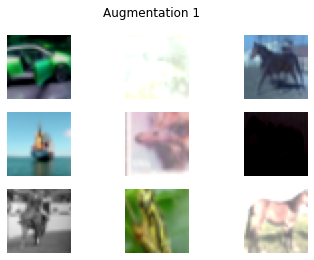

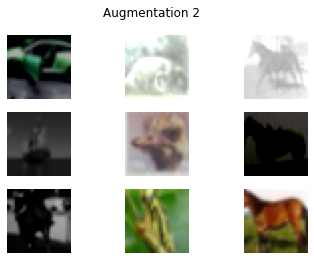

In [14]:
augment_versions = BTDatasetCreator(bt_augmentor)(train_features)
sample_augment_versions = iter(augment_versions)

def plot_values(batch: tuple):
    fig, axs = plt.subplots(3, 3)
    fig1, axs1 = plt.subplots(3, 3)

    fig.suptitle("Augmentation 1")
    fig1.suptitle("Augmentation 2")

    a1, a2 = batch

    # plots images on both tables
    for i in range(3):
        for j in range(3):
            # CHANGE(add / 255)
            axs[i][j].imshow(a1[3 * i + j])
            axs[i][j].axis("off")
            axs1[i][j].imshow(a2[3 * i + j])
            axs1[i][j].axis("off")

    plt.show()


plot_values(next(sample_augment_versions))

----------

## Pseudocode of loss and model
Barlow Twims要优于其他方法最重要的手段是，他在计算损失函数以及训练步骤的时候做出了改进，下图展示了PyTorch风格的伪码。

<img src='../images/CV_Img/Tlrootj.png'>

引用原文中变量表：  
* y_a: first augmented version of original image.
* y_b: second augmented version of original image.
* z_a: model representation(embeddings) of y_a.
* z_b: model representation(embeddings) of y_b.
* z_a_norm: normalized z_a.
* z_b_norm: normalized z_b.
* c: cross correlation matrix.
* c_diff: diagonal portion of loss(invariance term).
* off_diag: off-diagonal portion of loss(redundancy reduction term).

--------

## BarlowLoss: barlow twins model's loss function
Barlow Twins使用互相关矩阵来计算损失，主要有以下两个部分：
* **The invariance term**(diagonal). This part is used to make the diagonals of the matrix into 1s. When this is the case, the matrix shows that the images are correlated(same).
    * The loss function subtracts 1 from the diagonal and squares the values.
* **The redundancy reduction term**(off-diagonal). Here, the barlow twins loss function aims to make these values zero. As mentioned before, it is redundant if the representation neurons are correlated with values that are not on the diagonal.
    * Off diagonals are squared.

翻译：
* **不变项**（对角线）。对于相同的图像而言，这部分值为1.
    * loss=(对角线值-1)^2
* **冗余减少项**（非对角线）。算法旨在让这些部分值为零。如果这部分值非零，则说明模型冗余了。
    * loss=(非对角线值)^2

In [15]:
class BarlowLoss(keras.losses.Loss):
    def __init__(self, batch_size: int):
        super(BarlowLoss, self).__init__()
        self.lambda_amt = 5e-3          # 该值会用在互相关矩阵损失中
        self.batch_size = batch_size

    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        ''' 获得非对角线部分 '''
        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        """ 互相关矩阵整体loss计算方法

            对于两幅加强的图片而言，期望对角线值全为1，而非对角线值全为0.

        Loss function procedure:
            1. Invariance Term: (对角线值-1)^2 得到 c_diff
            2. Redundancy Reduction Term: 
                (1).使用 self.get_off_diag() 函数获得对角线值 _c
                (2).对 _c 进行平方再乘以 self.lambda_amt 得到 off_diag
            3.Loss = c_diff + off_diag
        """
        # subtracts diagonals by one and squares them(first part)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)
        # takes off diagonal, squares it, multiplies with lambda(second part)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt
        # sum first and second parts together
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)
        return loss

    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(
            output, axis=0
        )

    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        """ 互相关矩阵计算方法

            1. 将第一张图片的嵌入Embedding进行转置。
            2. 获得第二张图片的嵌入Embedding。
            3. 两个向量相乘可以得到一个 shape=(n_dense_units, n_dense_untis) 的矩阵，然后再除以 batch_size

        """
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size

    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        loss = self.cross_corr_matrix_loss(c)
        return loss

-----------

## Barlow Twins' Model Architecture
模型结构由两部分组成：
* The encoder network, which is a resnet-34.
* The projector network, which creates the model embeddings
    * This consists of an MLP with 3 dense-batchnorm-relu layers.

翻译：
* 编码部分用 resnet-34
* 映射层即Embedding层，3层附加Relu激活函数的全连接层。

### Encoder

In [16]:
class ResNet34:
    """Resnet34 class.
    模型参考了以下链接
        https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
        https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
    """

    def identity_block(self, x, filter):
        x_skip = x
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)

        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def convolutional_block(self, x, filter):
        x_skip = x
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same", strides=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)

        x_skip = tf.keras.layers.Conv2D(filter, (1, 1), strides=(2, 2))(x_skip)

        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def __call__(self, shape=(32, 32, 3)):

        x_input = tf.keras.layers.Input(shape)
        x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

        x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)

        block_layers = [3, 4, 6, 3]
        filter_size = 64

        for i in range(4):
            if i == 0:
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
            else:
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
        
        x = tf.keras.layers.AveragePooling2D((2, 2), padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
        return model

### 整体模型

In [17]:
def build_twin() -> keras.Model:
    # number of dense neurons in the projector 映射层神经元个数
    n_dense_neurons = 5000

    # encoder network 编码层
    resnet = ResNet34()()
    last_layer = resnet.layers[-1].output

    # intermediate layers of the projector network 映射层
    n_layers = 2
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{i}")
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f"projector_bn_{i}")(x)
        x = tf.keras.layers.ReLU(name=f"projector_relu_{i}")(x)

    x = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{n_layers}")(x)

    model = keras.Model(resnet.input, x)
    return model

------------

## Training Loop Model

In [18]:
class BarlowModel(keras.Model):
    def __init__(self):
        super(BarlowModel, self).__init__()
        self.model = build_twin()
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, batch: tf.Tensor) -> tf.Tensor:
        # get the two augmentations from the batch 从一个batch中获取两种增强结果
        y_a, y_b = batch

        with tf.GradientTape() as tape:
            # get two versions of predictions 得到两个映射向量
            z_a, z_b = self.model(y_a, training=True), self.model(y_b, training=True)
            loss = self.loss(z_a, z_b)

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

-----------

## Model Training
* Used the LAMB optimizer, instead of ADAM or SGD.
* Similar to the LARS optimizer used in the paper, and lets the model converge much faster than other methods.
* Expected training time: 1 hour 30 min. Go and eat a snack or take a nap or something.


翻译：
* 使用LAMB优化器代替ADAM或SGD。
* LAMB优化器类似于原文中的LARS优化器，同时要比其他优化器快很多。
* 在博主的电脑上预计160个epoch耗时 1h+30mim，但我们这里只训练10次看看。

In [ ]:
bm = BarlowModel()

optimizer = tfa.optimizers.LAMB()
loss = BarlowLoss(BATCH_SIZE)

bm.compile(optimizer=optimizer, loss=loss)

# Expected training time: 1 hours 30 min

history = bm.fit(augment_versions, epochs=10)
plt.plot(history.history["loss"])
plt.show()

我电脑实在跑不动，故不作演示了。

----------

## Evaluation
**Linear evaluation**: to evaluate the model's performance, we add a linear dense layer at the end and freeze the main model's weights, only letting the dense layer to be tuned. If the model actually learned something, then the accuracy would be significantly higher than random chance.  

**Accuracy on CIFAR-10** : 64% for this notebook. This is much better than the 10% we get from random guessing.  

翻译：
**线性评估**：冻结模型权重并在末尾添加一个全连接层，只是微调全连接层。如果模型真的学到了数据集的特征，那么该准确率将显著高于10%（在CIFAR-10数据集上）。  

**CIFAR-10准确率**：博主训练了160次后得到的准确率为64%。

In [ ]:
# Approx: 64% accuracy with this barlow twins model.

xy_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

model = keras.models.Sequential(
    [
        bm.model,
        keras.layers.Dense(
            10, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.02)
        ),
    ]
)

model.layers[0].trainable = False

linear_optimizer = tfa.optimizers.LAMB()
model.compile(
    optimizer=linear_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(xy_ds, epochs=35, validation_data=test_ds)

----------

## Conclusion
* Barlow Twins is a simple and concise method for contrastive and self-supervised learning.
* Barlow Twins 是一个非常简洁的对比学习和自监督学习算法。
* With this resnet-34 model architecture, we were able to reach 62-64% validation accuracy.
* 使用resnet-34结构的模型可以得到 62-64% 的验证准确率。

--------

## Use-Cases of Barlow-Twins(and contrastive learning in General)
* Semi-supervised learning: You can see that this model gave a 62-64% boost in accuracy when it wasn't even trained with the labels. It can be used when you have little labeled data but a lot of unlabeled data.
* 对于半监督学习而言，即使没有使用标签都可以达到62-64%的准确率，如果你的标签非常少（1:10）那么可以直接用自监督了。
* You do barlow twins training on the unlabeled data, and then you do secondary training with the labeled data.
* 如果你的标签数量还行，可以使用有标记的数据进行二次训练。